# Imports and Setup

We begin by importing the necessary packages: NumPy for random number generation and data structures, and Matplotlib for visualization.


In [8]:
import numpy as np
import matplotlib.pyplot as plt

# Function for Event and Time Sampling

This function implements the core of the Gillespie algorithm: sampling when the next event happens, and which event it is.

It uses the inverse transform method:
- `τ` is sampled from an exponential distribution.
- `k` is sampled from a discrete distribution defined by the normalized propensities.


In [11]:
# -------------------------------
# Core Function: Sample time and event index using Monte Carlo inversion
# -------------------------------
def sample_event_time(propensities, rng = np.random.default_rng()):
    """
    Given a list of propensities [a1, a2, ..., aK], sample:
    - Time until next event (tau) from Exp(sum of propensities)
    - Index of next event (k) based on relative weights

    Returns: (tau, event_index)
    """
    total_rate = sum(propensities)
    if total_rate == 0:
        return np.inf, None  # No events possible

    # Sample time using exponential distribution
    r1 = rng.uniform()
    tau = (1 / total_rate) * np.log(1 / r1)

    # Sample event index using inverse transform
    r2 = rng.uniform() * total_rate
    cumulative = 0.0
    for k, a in enumerate(propensities):
        cumulative += a
        if r2 <= cumulative:
            return tau, k

    return tau, len(propensities) - 1  # Shouldn't be reached, fallback

## Visualizing Event and Time Sampling

Here we generate and visualize samples from the event and time distributions for a fixed list of propensities. This builds intuition for how random numbers map onto events in the system.

Two examples with different propensities are shown below to highlight how the distributions change.



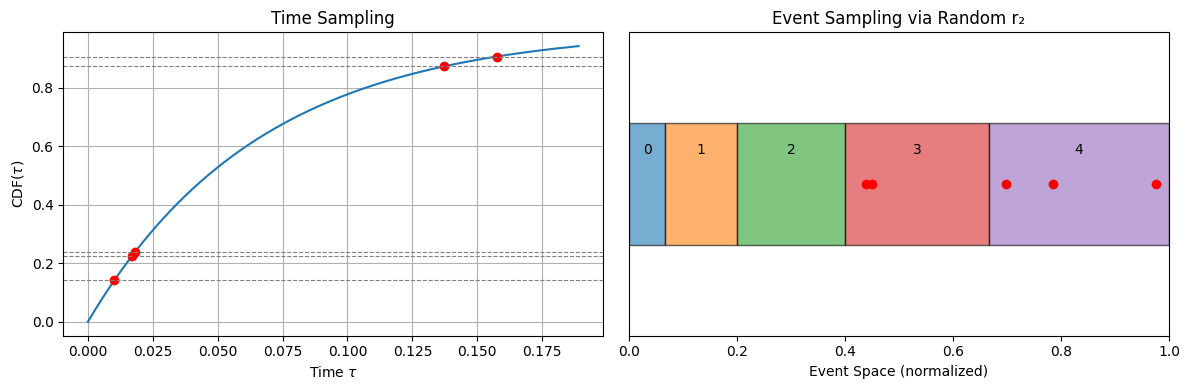

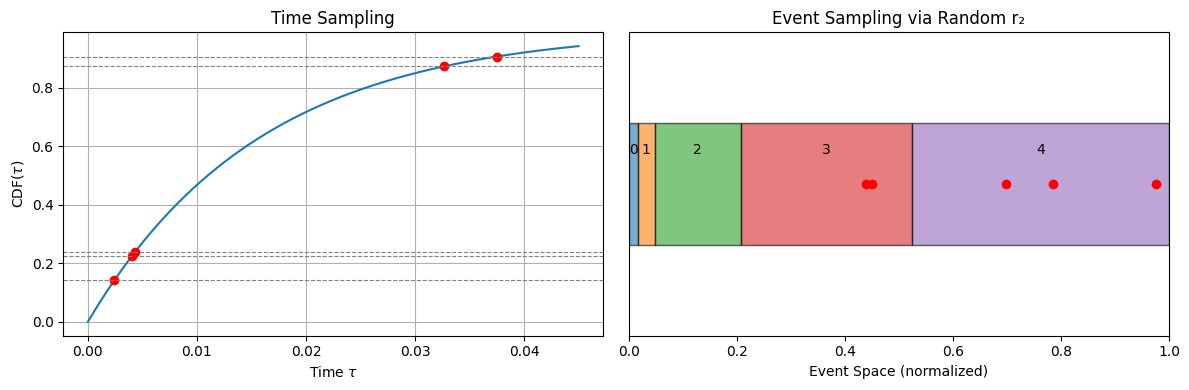

In [66]:
def visualize_sampling_with_bar(propensities, n_samples=5, seed=0):
    rng = np.random.default_rng(seed)
    rate_sum = sum(propensities)
    if rate_sum == 0:
        raise ValueError("Sum of propensities must be greater than zero.")

    # Sample tau and events
    sampled_taus = []
    sampled_events = []
    sampled_r1 = []
    sampled_r2 = []

    for _ in range(n_samples):
        r1 = rng.uniform()
        tau = (1 / rate_sum) * np.log(1 / r1)
        r2 = rng.uniform() * rate_sum
        cumulative = 0.0
        for k, a in enumerate(propensities):
            cumulative += a
            if r2 <= cumulative:
                event = k
                break
        else:
            event = len(propensities) - 1

        sampled_taus.append(tau)
        sampled_events.append(event)
        sampled_r1.append(r1)
        sampled_r2.append(r2)

    # Proportional bar positions
    widths = np.array(propensities) / rate_sum
    lefts = np.cumsum(np.pad(widths[:-1], (1, 0)))
    labels = [f'{i}' for i in range(len(propensities))]

    # Plotting: Time CDF + Bar representation
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # --- Time CDF ---
    tau_values = np.linspace(0, max(sampled_taus) * 1.2, 500)
    cdf_time = 1 - np.exp(-rate_sum * tau_values)
    ax1.plot(tau_values, cdf_time, label='CDF of Exp(λ={:.1f})'.format(rate_sum))
    for i in range(n_samples):
        tau_i = sampled_taus[i]
        r1_i = sampled_r1[i]
        ax1.plot([tau_i], [1 - np.exp(-rate_sum * tau_i)], 'ro')
        ax1.axhline(1 - r1_i, color='gray', linestyle='--', linewidth=0.8)
    ax1.set_xlabel(r'Time $\tau$')
    ax1.set_ylabel(r'CDF($\tau$)')
    ax1.set_title('Time Sampling')
    ax1.grid(True)

    # --- Bar plot version (better event visualization) ---
    for i in range(len(propensities)):
        ax2.barh(0, width=widths[i], left=lefts[i], height=0.4, alpha=0.6, edgecolor='black')
        ax2.text(lefts[i] + widths[i]/2, 0.1, labels[i], ha='center', fontsize=10)
    ax2.set_xlim(0, 1)
    ax2.set_ylim(-0.5, 0.5)
    ax2.set_yticks([])
    ax2.set_xlabel("Event Space (normalized)")
    ax2.set_title("Event Sampling via Random r₂")

    for r2 in sampled_r2:
        ax2.plot(r2 / rate_sum, 0, 'ro')

    plt.tight_layout()
    plt.show()

# Example usage
visualize_sampling_with_bar([1.0, 2.0, 3.0,4,5], n_samples=5, seed=42)
visualize_sampling_with_bar([1.0, 2.0, 10.0,20,30], n_samples=5, seed=42)


# Core Gillespie Simulation Framework

This function implements the modular version of the Gillespie algorithm. It takes:
- a function to compute the propensities given the state,
- a list of update functions for each event type,
- and a maximum simulation time.


In [68]:
def simulate_dynamic_process(initial_state, get_propensities, updates, t_max, rng=np.random.default_rng()):
    """
    Gillespie simulator with dynamic propensity evaluation.

    Parameters:
    - initial_state: system state (scalar, vector, or object)
    - get_propensities: function(state, time) -> list of current rates
    - updates: list of state update functions (index-aligned with propensities)
    - t_max: simulation time horizon
    - rng: NumPy random number generator

    Returns:
    - times: array of event times
    - states: array of system states at each event
    """
    # Initialize time and state history
    t = 0.0
    state = initial_state
    times = [t]
    states = [state]

    # Compute initial propensities
    rates = get_propensities(state)

    while t < t_max:
        # Check if any events are possible
        if sum(rates) == 0:
            break

        # Sample time and event index using pre-defined function
        tau, event_idx = sample_event_time(rates, rng)

        # If no event is selected, exit
        if event_idx is None or np.isinf(tau):
            break

        # Advance time
        t += tau
        if t > t_max:
            break

        # Update state based on selected event
        state = updates[event_idx](state)

        # Record new time and state
        times.append(t)
        states.append(state)

        # Recompute propensities after update
        rates = get_propensities(state)

    return np.array(times), np.array(states)


# Example Birth Process

The **pure birth process** is one of the simplest examples of a discrete stochastic system. It models a population where each individual gives rise to new individuals at a constant per-capita rate.

In this setup:
- The **state** of the system is the current population size \( N \).
- The **only event** is a birth: \( N \rightarrow N + 1 \), occurring at rate \( \lambda N \), where \( \lambda \) is the birth rate per individual.

We now implement this process in a **modular way**:
- A function returns the current **propensity** (i.e. the birth rate).
- A corresponding function **updates the state** when a birth occurs.

### Analytical Results (from the Master Equation)

If the system starts at \( N(0) = N_0 \), the expected population and its variance at time \( t \) are:

- **Mean**:
  $$
  \mathbb{E}[N(t)] = N_0 e^{\lambda t}
  $$

- **Variance**:
  $$
  \text{Var}[N(t)] = N_0 e^{\lambda t}(e^{\lambda t} - 1)
  $$

These expressions provide a useful benchmark when comparing to stochastic simulations.


In [69]:
def get_birth_process(lambda_rate):
    """
    Returns modular components for simulating a pure birth process:
    N → N + 1 at rate λN

    Parameters:
    - lambda_rate: birth rate coefficient (λ)

    Returns:
    - get_propensities(state, time): returns [λN]
    - updates: list of update functions (here, just one: N → N+1)
    """
    # Define birth propensity as a function of state
    def birth_rate(N): return lambda_rate * N

    # Wrap in get_propensities(state, time)
    def get_propensities(state):
        return [birth_rate(state)]

    # Define corresponding update
    updates = [lambda N: N + 1]

    return get_propensities, updates


def simulate_birth_process(N0=1, lambda_rate=1.0, t_max=10.0, seed=42):
    """
    Runs a pure birth process simulation using the modular Gillespie method.

    Parameters:
    - N0: initial population
    - lambda_rate: birth rate coefficient λ
    - t_max: maximum simulation time
    - seed: RNG seed for reproducibility

    Returns:
    - times: array of event times
    - states: array of state values N(t) at each time
    """
    rng = np.random.default_rng(seed)

    # Get process definition
    get_propensities, updates = get_birth_process(lambda_rate)

    # Run simulation
    times, states = simulate_dynamic_process(N0, get_propensities, updates, t_max, rng)

    return times, states

## Visualizing Multiple Birth Process Setups

Here we simulate the birth process under different initial conditions and birth rates. We plot:
- the population over time for each example,
- and a raster plot showing when events occur for each case.


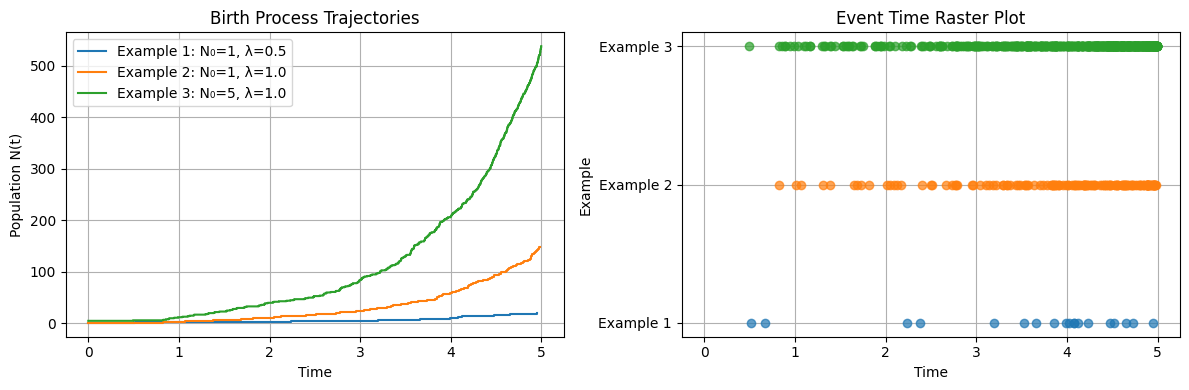

In [70]:
def plot_birth_trajectories_and_event_raster(seed = 123):
    t_max = 5.0
    rng = np.random.default_rng(seed=seed)

    # Parameter sets to simulate
    params = [
        {"N0": 1, "lambda": 0.5},
        {"N0": 1, "lambda": 1.0},
        {"N0": 5, "lambda": 1.0},
    ]

    fig, axs = plt.subplots(1, 2, figsize=(12, 4), sharex=True)

    for idx, p in enumerate(params):
        times, states = simulate_birth_process(p["N0"], p["lambda"], t_max, rng)
        label = f"Example {idx+1}: N₀={p['N0']}, λ={p['lambda']}"

        # Trajectory (left plot)
        axs[0].step(times, states, where='post', label=label)

        # Event time dot raster (right plot)
        axs[1].plot(times[1:], [idx + 1] * (len(times) - 1), 'o', label=label, alpha=0.7)

    # Format trajectory plot
    axs[0].set_title("Birth Process Trajectories")
    axs[0].set_xlabel("Time")
    axs[0].set_ylabel("Population N(t)")
    axs[0].legend()
    axs[0].grid(True)

    # Format raster event plot
    axs[1].set_title("Event Time Raster Plot")
    axs[1].set_xlabel("Time")
    axs[1].set_yticks(range(1, len(params) + 1))
    axs[1].set_yticklabels([f"Example {i+1}" for i in range(len(params))])
    axs[1].set_ylabel("Example")
    axs[1].grid(True)

    plt.tight_layout()
    plt.show()

# Run it
plot_birth_trajectories_and_event_raster(seed=42)


## Comparing Multiple Stochastic Trajectories

We now simulate the birth process many times with the same parameters to observe:
- the spread of trajectories,
- the exact theoretical mean and variance.

This highlights the stochastic nature of the process even when parameters are fixed.


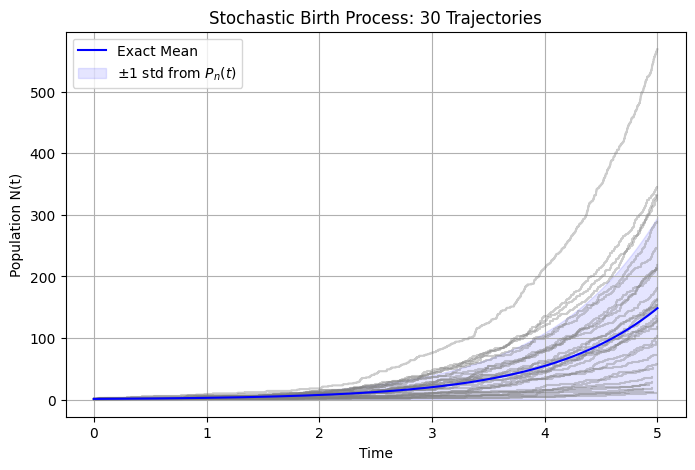

In [65]:
def plot_multiple_birth_trajectories(N0, lambda_rate, t_max, n_runs=30, seed=123):
    rng = np.random.default_rng(seed)
    plt.figure(figsize=(8, 5))

    t_vals = np.linspace(0, t_max, 300)
    exact_mean = N0 * np.exp(lambda_rate * t_vals)
    exact_std = np.sqrt(N0 * np.exp(lambda_rate * t_vals) * (np.exp(lambda_rate * t_vals) - 1))

    # Simulate and plot individual trajectories
    for i in range(n_runs):
        times, states = simulate_birth_process(N0, lambda_rate, t_max, rng)
        plt.step(times, states, where='post', alpha=0.4, color='gray')

    # Overlay exact mean and variance band
    plt.plot(t_vals, exact_mean, 'b-', label="Exact Mean")
    plt.fill_between(t_vals, exact_mean - exact_std, exact_mean + exact_std,
                     color='blue', alpha=0.1, label="±1 std from $P_n(t)$")

    plt.xlabel("Time")
    plt.ylabel("Population N(t)")
    plt.title(f"Stochastic Birth Process: {n_runs} Trajectories")
    plt.legend()
    plt.grid(True)
    plt.show()

# Example usage
plot_multiple_birth_trajectories(N0=1, lambda_rate=1.0, t_max=5.0, n_runs=30, seed=42)
